In [34]:
## Importing the required libraries

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
# Reading the CSV file
df_IBM = pd.read_csv("./data/IBMStockPrice.csv", index_col="Date")

# Converting Index datatype to Datetime
df_IBM.index = pd.to_datetime(df_IBM.index)
df_IBM = df_IBM.loc["2020-01-01":"2024-02-23"]
df_IBM

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,135.00,135.920,134.7700,135.42,3148461
2020-01-03,133.57,134.860,133.5600,134.34,2373470
2020-01-06,133.42,134.240,133.2000,134.10,2421128
2020-01-07,133.69,134.960,133.4000,134.19,3267592
2020-01-08,134.51,135.860,133.9200,135.31,4345952
...,...,...,...,...,...
2024-02-16,186.63,188.950,185.9452,187.64,4842840
2024-02-20,187.64,188.770,183.0600,183.44,4247181
2024-02-21,182.56,183.030,178.7500,179.70,4728473


In [11]:
# Taking the "Close" as our target feature
dfClose = df_IBM[["Close"]]
dfClose

,Close
Date,
2020-01-02,135.42
2020-01-03,134.34
2020-01-06,134.10
2020-01-07,134.19
2020-01-08,135.31
...,...
2024-02-16,187.64
2024-02-20,183.44
2024-02-21,179.70


<Axes: xlabel='Date'>

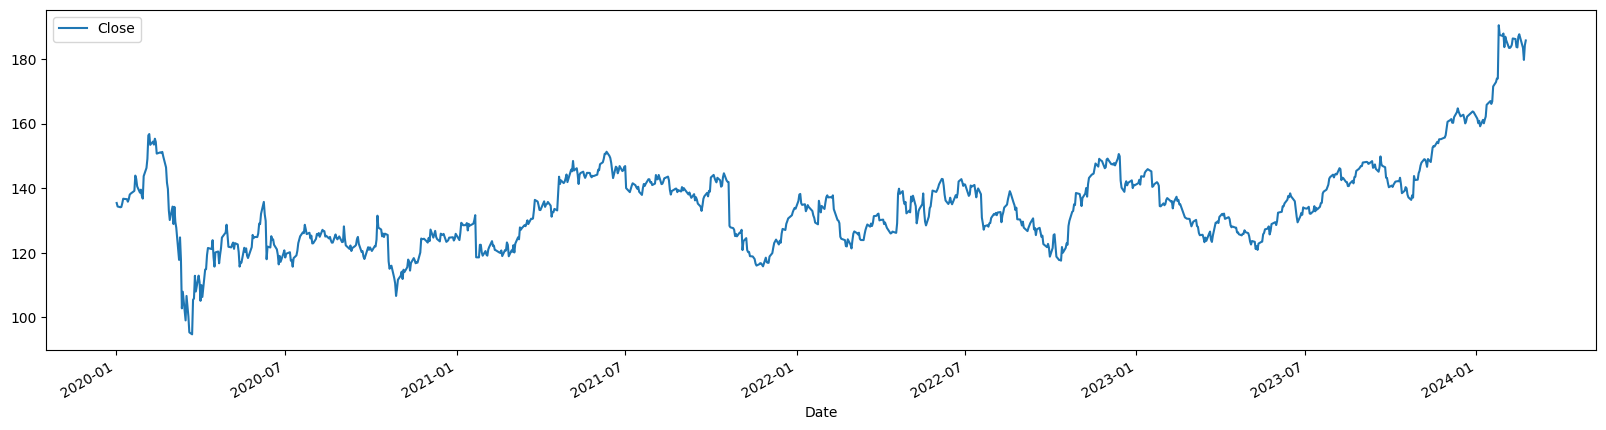

In [9]:
# Plotting the Close feature of the Stock Dataset
df_IBM[["Close"]].plot(figsize=(20,5))

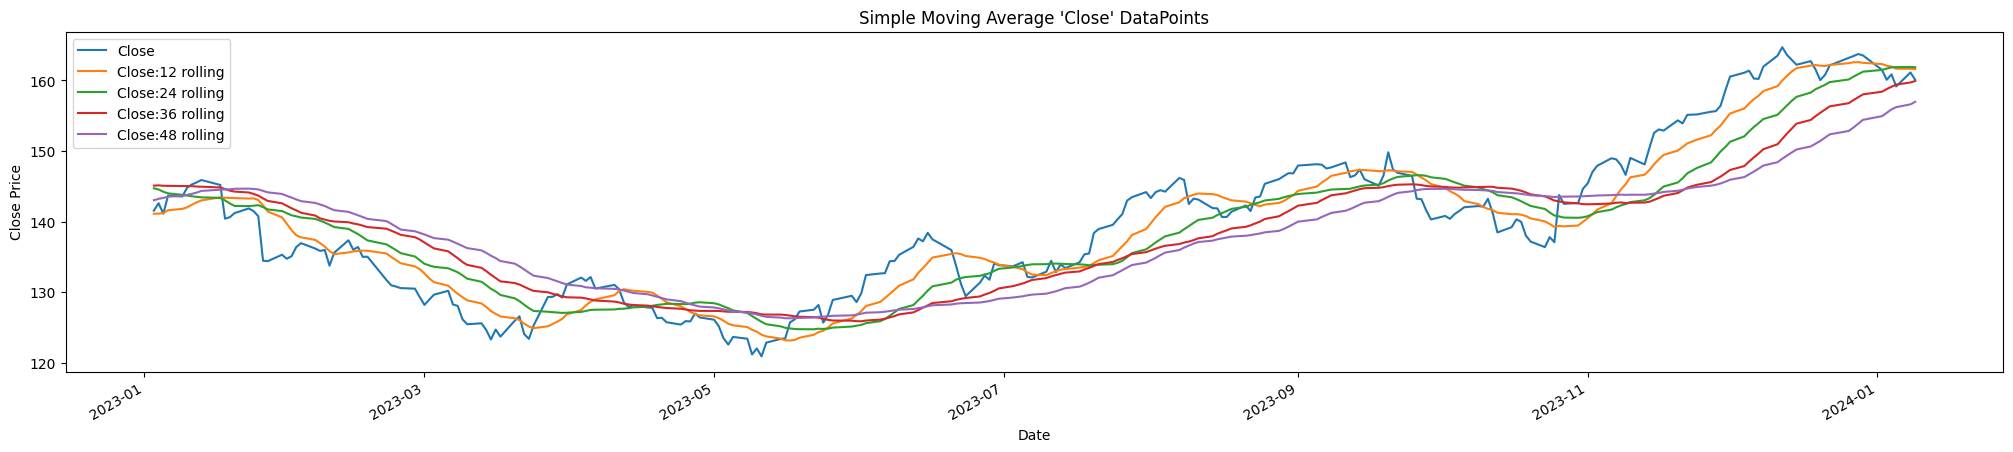

In [10]:
# Computing Simple moving average over the multiple windows and plotting them
df_IBM["Close:12 rolling"] = df_IBM["Close"].rolling(window=12, min_periods=1).mean()
df_IBM["Close:24 rolling"] = df_IBM["Close"].rolling(window=24, min_periods=1).mean()
df_IBM["Close:36 rolling"] = df_IBM["Close"].rolling(window=36, min_periods=1).mean()
df_IBM["Close:48 rolling"] = df_IBM["Close"].rolling(window=48, min_periods=1).mean()

df_IBM[["Close", "Close:12 rolling", "Close:24 rolling", "Close:36 rolling", "Close:48 rolling"]].loc["2023-01-01":"2024-01-09"].plot(ylabel="Close Price", figsize=(25,5))
plt.title("Simple Moving Average 'Close' DataPoints")
plt.show()

## Time Series Analysis
A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

### The Following are the componenet Analysis

1. The Average value in the series is called Level.
2. The Increasing or falling value in the series in refered to as the end of trend.
3. Seasonality is the series recurring short-term cycle
4. The random variance is the series is refered to as noise.

Because time series analysis only works with stationary data, we must determine whether the series is stationary or not.

### ADF (Augmented Dickey-Fuller) Test

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a = 1) / Time Series is Not-stationary

Alternate Hypothesis: The series has no unit root. / The Time series is stationary

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

## ARIMA
1. AutoRegression (AR)  ---> done by ---> PACF (Partial Auto Correlation)
2. Moving Average (MA) ---> done by ---> ACF (Auto Correlation)
3. Integrated (I) ---> done by ---> Differential

In [18]:
# ADF Test
def adf_test(series):
    result = adfuller(series)
    output = pd.Series(result[0:4],index=['ADF Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in result[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [19]:
adf_test(dfClose[["Close"]])

ADF Test Statistics              -1.772089
p-value                           0.394404
No. of lags used                  9.000000
Number of observations used    1033.000000
critical value (1%)              -3.436696
critical value (5%)              -2.864342
critical value (10%)             -2.568262
dtype: float64


Comparing the ADF test statistic to the critical values, we observe that the test statistic is not more extreme than the critical values at the 1%, 5%, and 10% significance levels. Therefore, based on the p-value and critical values, we do not have enough evidence to reject the null hypothesis of a unit root in the time series. This suggests that the time series may be non-stationary.

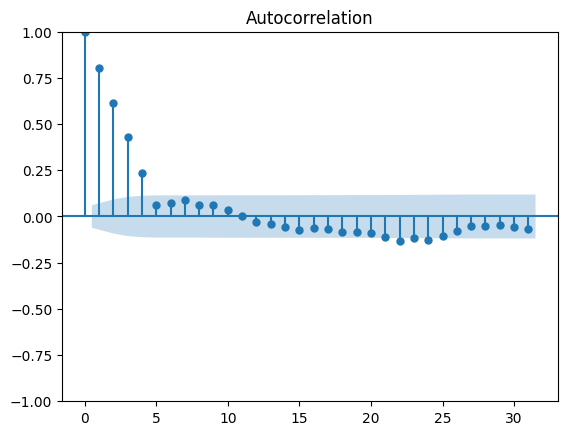

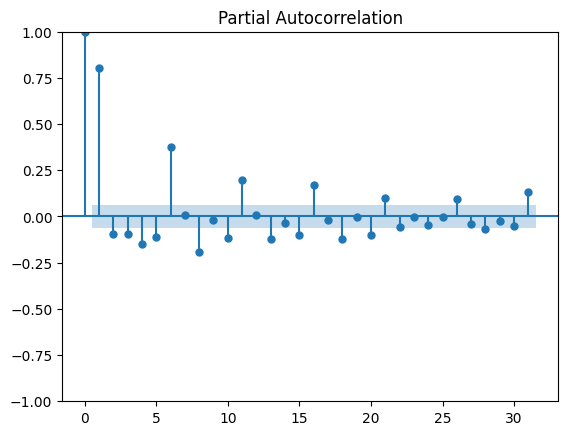

In [24]:
# As Data isn't stationary, performing Differencing

shifted = dfClose["Close"]-dfClose["Close"].shift(5)

## Plotting acf and pacf
acf = plot_acf(shifted.dropna())

pacf = plot_pacf(shifted.dropna())

In [61]:
## Performing ADF test for the shifted timeseries

adf_test(shifted.dropna())

ADF Test Statistics           -7.459885e+00
p-value                        5.388796e-11
No. of lags used               2.100000e+01
Number of observations used    1.016000e+03
critical value (1%)           -3.436803e+00
critical value (5%)           -2.864389e+00
critical value (10%)          -2.568287e+00
dtype: float64


Comparing the ADF test statistic to the critical values and considering the extremely low p-value, the evidence strongly supports the rejection of the null hypothesis of a unit root. Therefore, you can reasonably conclude that the time series data is stationary. This is a positive outcome for applying models like ARIMA or SARIMAX, which generally assume stationarity in the data.

In [26]:
# Splitting the dataset into train and test dataset for model training

test_ratio = 0.1
training_ratio = 1 - test_ratio
train_size = int(training_ratio * len(dfClose))
test_size = int(test_ratio * len(dfClose))
sampleTrain = dfClose[:train_size]
sampleTest = dfClose[train_size:]

In [27]:
## ARIMA

arimaModel = SARIMAX(sampleTrain["Close"], order=(6,5,2))  
arimaFitted = arimaModel.fit()
arimaFitted.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18222D+00    |proj g|=  1.62386D+00

At iterate    5    f=  2.82633D+00    |proj g|=  8.40836D-02

At iterate   10    f=  2.74445D+00    |proj g|=  4.53044D-02

At iterate   15    f=  2.69851D+00    |proj g|=  2.57378D-01

At iterate   20    f=  2.56675D+00    |proj g|=  1.37492D-01

At iterate   25    f=  2.47145D+00    |proj g|=  6.38661D-02

At iterate   30    f=  2.44906D+00    |proj g|=  1.32217D-02

At iterate   35    f=  2.44578D+00    |proj g|=  1.80995D-03

At iterate   40    f=  2.44551D+00    |proj g|=  7.15208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  938
Model:               SARIMAX(6, 5, 2)   Log Likelihood               -2293.888
Date:                Sat, 24 Feb 2024   AIC                           4605.775
Time:                        18:53:30   BIC                           4649.321
Sample:                             0   HQIC                          4622.381
                                - 938                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5193      0.024    -62.674      0.000      -1.567      -1.472
ar.L2         -1.6271      0.045    -35.951      0.000      -1.716      -1.538
ar.L3         -1.4607      0.058    -25.168      0.000      -1.574      -1.347
ar.L4         -1.1567      0.055    -20.867      0.000      -1.265      -1.048
ar.L5         -0.7135      0.045    -16.025      0.000      -0.801      -0.626
ar.L6         -0.3577      0.023    -15.275      0.000      -0.404      -0.312
ma.L1         -1.9989      0.278     -7.180      0.000      -2.545      -1.453
ma.L2          0.9993      0.278      3.589      0.000       0.454       1.545
sigma2         7.7397      2.100      3.685      0.000       3.623      11.857
===================================================================================
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):               463.70
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2020-01-02 00:00:00
2023-09-22 00:00:00


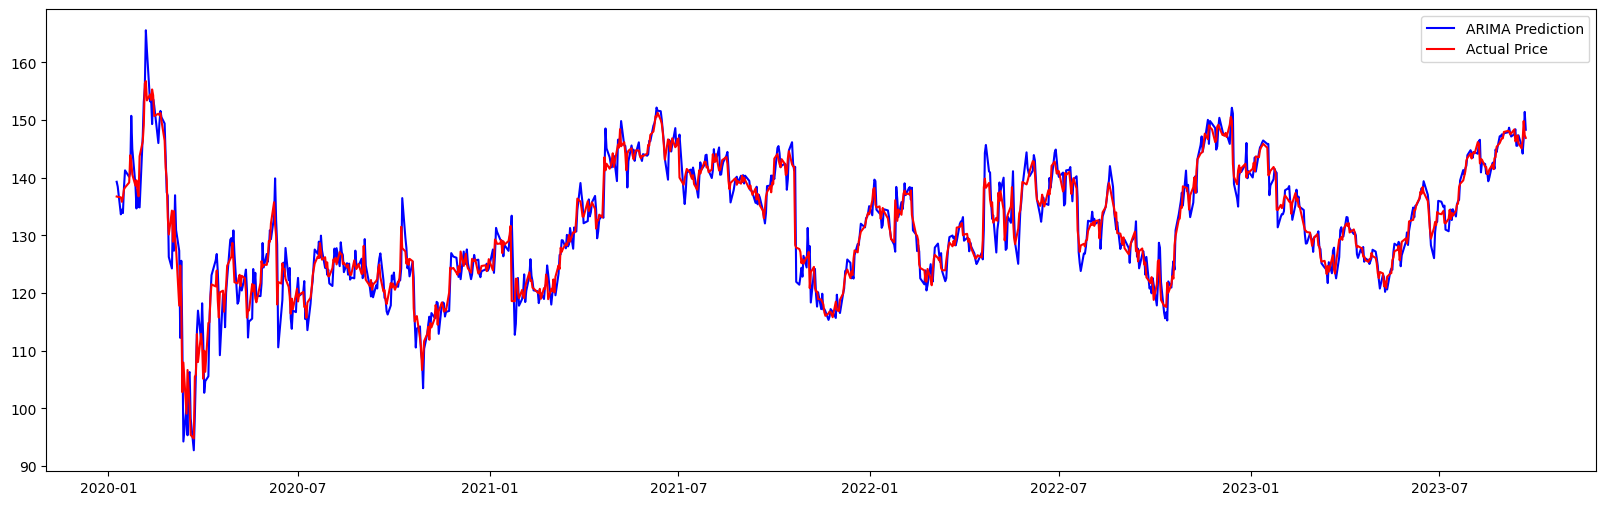

In [32]:
## Plotting the Arima prediction with our actual values

pred_start_date=sampleTrain.index[0]
pred_end_date=sampleTrain.index[-1]
print(pred_start_date)
print(pred_end_date)

arimaPred = arimaFitted.predict(start=pred_start_date , end=pred_end_date)
# print(arimaPred)
# print(predValues)
# print(sampleTrain)

plt.figure(figsize=(20,6))
plt.plot(arimaPred[5:], color="blue", label="ARIMA Prediction")
plt.plot(sampleTrain[5:], color="red", label="Actual Price")
plt.legend()
plt.show()

In [35]:
## Computing MSE, MAE and RMSE for ARIMA

mse = mean_squared_error(sampleTrain[3:], arimaPred[3:])
print('MSE:', mse)
mae = mean_absolute_error(sampleTrain[3:], arimaPred[3:])
print('MAE:', mae)
rmse = math.sqrt(mse)
print('RMSE:', rmse)

MSE: 8.99301386606574
MAE: 2.051569875144511
RMSE: 2.998835418302535


In [30]:
## SARIMAX

model = SARIMAX(sampleTrain["Close"], order=(6,0,2), seasonal_order=(0,1,0,5))  
sampleFitted = model.fit()
sampleFitted.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38423D+00    |proj g|=  7.17757D-02

At iterate    5    f=  2.36914D+00    |proj g|=  8.31339D-02

At iterate   10    f=  2.36286D+00    |proj g|=  1.42404D-02


 This problem is unconstrained.



At iterate   15    f=  2.36064D+00    |proj g|=  1.95730D-02

At iterate   20    f=  2.35752D+00    |proj g|=  2.63921D-02

At iterate   25    f=  2.33964D+00    |proj g|=  1.09687D-01

At iterate   30    f=  2.33142D+00    |proj g|=  1.36702D-01

At iterate   35    f=  2.32823D+00    |proj g|=  1.13674D-01

At iterate   40    f=  2.32686D+00    |proj g|=  6.81571D-02

At iterate   45    f=  2.32664D+00    |proj g|=  6.99081D-03

At iterate   50    f=  2.32659D+00    |proj g|=  3.58558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   3.586D-02   2.327D+00
  F =   2.32658730404

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  938
Model:             SARIMAX(6, 0, 2)x(0, 1, [], 5)   Log Likelihood               -2182.339
Date:                            Sat, 24 Feb 2024   AIC                           4382.678
Time:                                    18:55:51   BIC                           4426.223
Sample:                                         0   HQIC                          4399.284
                                            - 938                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4005      0.022     64.314      0.000       1.358       1.443
ar.L2         -1.2139      0.033    -36.843      0.000      -1.278      -1.149
ar.L3          0.7019      0.035     20.320      0.000       0.634       0.770
ar.L4         -0.2012      0.044     -4.599      0.000      -0.287      -0.115
ar.L5         -0.0645      0.041     -1.562      0.118      -0.146       0.016
ar.L6          0.1087      0.024      4.499      0.000       0.061       0.156
ma.L1         -0.6169      0.010    -60.765      0.000      -0.637      -0.597
ma.L2          0.9980      0.026     37.940      0.000       0.946       1.050
sigma2         6.1838      0.220     28.134      0.000       5.753       6.615
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1220.68
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2020-01-02 00:00:00
2023-09-22 00:00:00


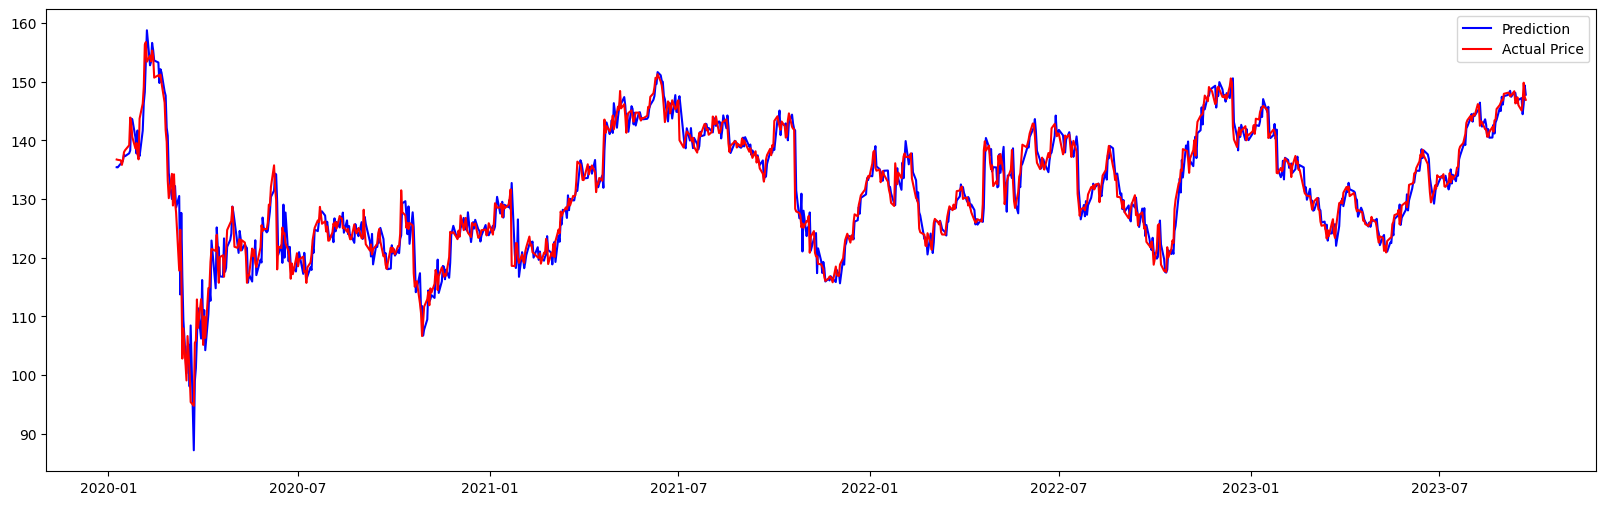

In [33]:
## Plotting the SARIMAX prediction with our actual values

pred_start_date=sampleTrain.index[0]
pred_end_date=sampleTrain.index[-1]
print(pred_start_date)
print(pred_end_date)

predValues = sampleFitted.predict(start=pred_start_date , end=pred_end_date)
# print(predValues[3:])

plt.figure(figsize=(20,6))
plt.plot(predValues[5:], color="blue", label="Prediction")
plt.plot(sampleTrain[5:], color="red", label="Actual Price")
plt.legend()
plt.show()

In [36]:
## Computing MSE, MAE and RMSE for SARIMAX

mse = mean_squared_error(sampleTrain[3:], predValues[3:])
print('MSE:', mse)
mae = mean_absolute_error(sampleTrain[3:], predValues[3:])
print('MAE:', mae)
rmse = math.sqrt(mse)
print('RMSE:', rmse)

MSE: 45.16394844737609
MAE: 2.0450923112292543
RMSE: 6.720412818225983


In [40]:
arimaPred

Date
2020-01-02      0.000000
2020-01-03    406.272685
2020-01-06     -3.780827
2020-01-07    163.269381
2020-01-08    131.664225
                 ...    
2023-09-18    145.549883
2023-09-19    144.187446
2023-09-20    146.733293
2023-09-21    151.418324
2023-09-22    148.317195
Name: predicted_mean, Length: 938, dtype: float64

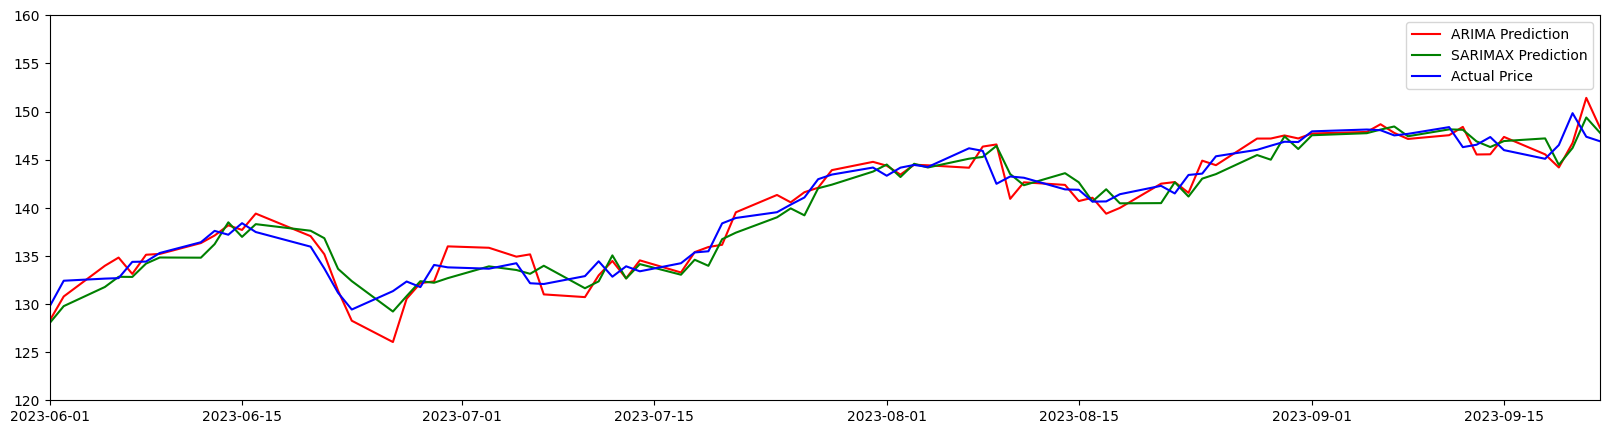

In [46]:
## Plotting for a range to date

start_date = datetime(2023,6,1)
end_date = datetime(2023,9,22)

plt.figure(figsize=(20,5))
plt.xlim([start_date, end_date])
plt.ylim([120,160])
plt.plot(arimaPred, color="red", label="ARIMA Prediction")
plt.plot(predValues, color="green", label="SARIMAX Prediction")
plt.plot(sampleTrain, color="Blue", label="Actual Price")
plt.legend()
plt.show()

In [53]:
## Future Prediction
start_date = datetime(2023,9,23)
end_date = datetime(2024,2,23)

n_steps = 102
new_index = sampleTest[:n_steps].index
arimaFuturePred = arimaFitted.forecast(steps=n_steps)
arimaFuturePred = pd.Series(arimaFuturePred.values, index=new_index)
sarimaxFuturePred = sampleFitted.forecast(steps=n_steps)
sarimaxFuturePred = pd.Series(sarimaxFuturePred.values, index=new_index)

print("ARIMA Future Prediction \n", arimaFuturePred)
print("")
print("SARIMAX Future Prediction \n", sarimaxFuturePred)

ARIMA Future Prediction 
 Date
2023-09-25     146.681142
2023-09-26     146.144767
2023-09-27     146.141633
2023-09-28     145.480595
2023-09-29     144.619609
                 ...     
2024-02-13    -936.971628
2024-02-14    -965.286609
2024-02-15    -994.130878
2024-02-16   -1023.511444
2024-02-20   -1053.435363
Length: 102, dtype: float64

SARIMAX Future Prediction 
 Date
2023-09-25    147.179648
2023-09-26    146.436187
2023-09-27    147.627939
2023-09-28    146.033940
2023-09-29    147.162415
                 ...    
2024-02-13    147.755114
2024-02-14    146.257836
2024-02-15    147.086065
2024-02-16    147.342628
2024-02-20    146.337341
Length: 102, dtype: float64


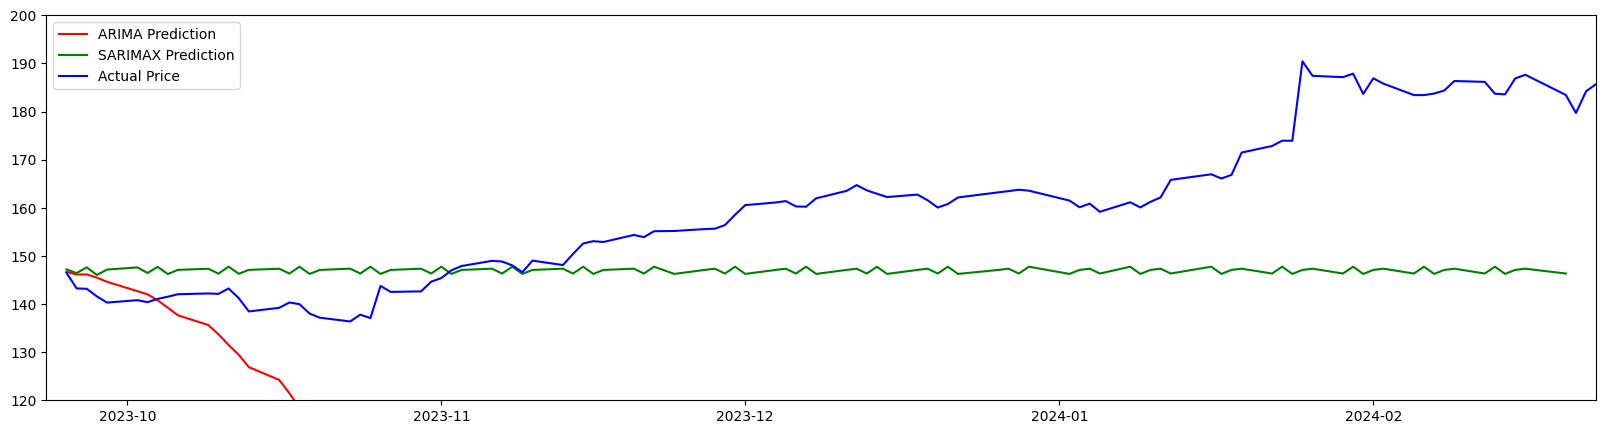

In [54]:
plt.figure(figsize=(20,5))
plt.xlim([start_date, end_date])
plt.ylim([120,200])
plt.plot(arimaFuturePred, color="red", label="ARIMA Prediction")
plt.plot(sarimaxFuturePred, color="green", label="SARIMAX Prediction")
plt.plot(sampleTest, color="Blue", label="Actual Price")
plt.legend()
plt.show()

# LSTM (Long Short-Term Memory)

In [62]:
## Importing the required libraries to train LSTM

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from math import ceil

In [77]:
shape = df_IBM.shape[0]
df_new=df_IBM[['Close']]
dataset = df_new.values
train = df_new.iloc[:ceil(shape * 0.9)]
valid = df_new.iloc[ceil(shape * 0.9):]
print('-----------------------------------------------------------------------------')
print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
print('-----------------------------------------------------------------------------')
print('Shape of Training Set',train.shape)
print('Shape of Validation Set',valid.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_new)
x_train, y_train = [], []
for i in range(40,len(train)):
    x_train.append(scaled_data[i-40:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (939, 1)
Shape of Validation Set (104, 1)
Epoch 1/15
899/899 - 8s - loss: 0.0031 - 8s/epoch - 9ms/step
Epoch 2/15
899/899 - 7s - loss: 0.0014 - 7s/epoch - 8ms/step
Epoch 3/15
899/899 - 7s - loss: 0.0010 - 7s/epoch - 8ms/step
Epoch 4/15
899/899 - 7s - loss: 8.3406e-04 - 7s/epoch - 8ms/step
Epoch 5/15
899/899 - 7s - loss: 7.8720e-04 - 7s/epoch - 8ms/step
Epoch 6/15
899/899 - 7s - loss: 7.4387e-04 - 7s/epoch - 8ms/step
Epoch 7/15
899/899 - 7s - loss: 7.3832e-04 - 7s/epoch - 8ms/step
Epoch 8/15
899/899 - 7s - loss: 7.0255e-04 - 7s/epoch - 8ms/step
Epoch 9/15
899/899 - 7s - loss: 7.1373e-04 - 7s/epoch - 8ms/step
Epoch 10/15
899/899 - 7s - loss: 7.3065e-04 - 7s/epoch - 8ms/step
Epoch 11/15
899/899 - 7s - loss: 7.0641e-04 - 7s/epoch - 8ms/st

In [78]:
inputs = df_new[len(df_new) - len(valid) - 40:]
# print(inputs)
inputs.values.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
opening_price = model.predict(X_test)
opening_price= scaler.inverse_transform(opening_price)
rms=np.sqrt(np.mean(np.power((valid-opening_price),2)))
print('RMSE value on validation set:',rms)

4/4 [==============================] - 1s 5ms/step
RMSE value on validation set: 3.5664557659790934


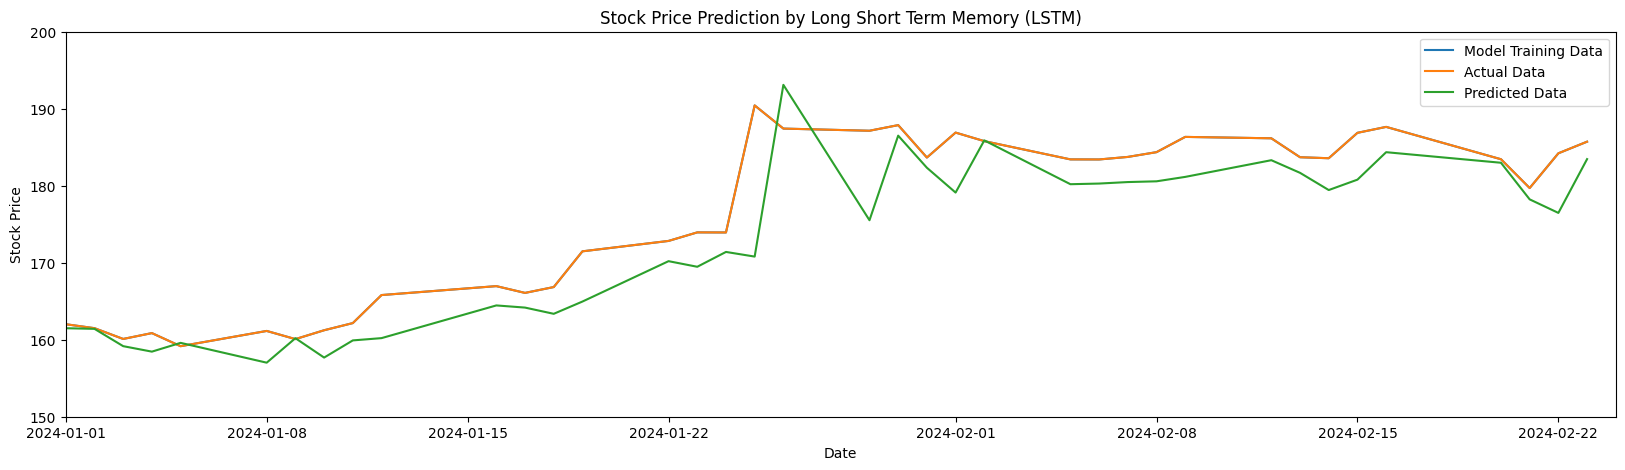

In [88]:
#Visualize the prediction
plt.figure(figsize=(20,5), dpi=100)
valid['Predictions'] = opening_price
plt.plot(df_new['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Date')
plt.xlim(datetime(2024,1,1), datetime(2024,2,24))
plt.ylim(150,200)
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)')
plt.legend(['Model Training Data','Actual Data','Predicted Data'])
plt.show()